In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import glob
from scipy.stats import ks_2samp, kstest
import corner

%matplotlib inline

In [3]:
def load_summary(filename):
    dtype=[('minr', 'f8'),
           ('maxr', 'f8'), 
           ('ca_ratio', 'f8'),
           ('ba_ratio', 'f8'),
           ('a', 'f8'),
           ('center', 'f8'),
           ('width', 'f8'),
           ('mu', 'f8')]
    summary = np.loadtxt(filename, dtype=dtype)    
    return summary

In [4]:
def load_experiment(input_path="../data/mstar_selected_summary/vmax_sorted/", fixed_number=False, full_data=False):
    files = glob.glob(input_path+"M31_group_*")
    group_id = []
    for f in files:
        i = int(f.split("_")[-5])
        if i not in group_id:
            group_id.append(i)
    print(group_id, len(group_id))

    n_groups = len(group_id)

    if fixed_number:
        n_iter = np.arange(5)
    else:
        n_iter = np.arange(11,16)
    
    fields = ['width','ca_ratio', 'ba_ratio']
    M31_all = {}
    MW_all = {}
    if not full_data:
        for field in fields:
            M31_all[field] = np.ones(n_groups)
            MW_all[field] = np.ones(n_groups)
            M31_all[field+'_sigma'] = np.ones(n_groups)
            MW_all[field+'_sigma'] = np.ones(n_groups)
        
            M31_all[field+'_random'] = np.ones(n_groups)
            MW_all[field+'_random'] = np.ones(n_groups)
            M31_all[field+'_random_sigma'] = np.ones(n_groups)
            MW_all[field+'_random_sigma'] = np.ones(n_groups)
    else:
        for field in fields:
            M31_all[field] = np.empty((0))
            MW_all[field] = np.empty((0))
            M31_all[field+'_random'] = np.empty((0))
            MW_all[field+'_random'] = np.empty((0))
           

    for g in range(n_groups):

        MW_summary = {}
        M31_summary = {}
    
        for i in n_iter:
            if fixed_number:
                filename_MW = os.path.join(input_path,"MW_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], 11, i))
                filename_M31 = os.path.join(input_path,"M31_group_{}_nmax_{}_iter_{}.dat".format(group_id[g],11, i))
            else:
                filename_MW = os.path.join(input_path,"MW_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], i, 0))
                filename_M31 = os.path.join(input_path,"M31_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], i, 0))

            MW_summary[i] = load_summary(filename_MW)
            M31_summary[i] = load_summary(filename_M31)
    
        
        for field in fields:
            a = np.empty((0))
            b = np.empty((0))
            a_random = np.empty((0))
            b_random = np.empty((0))
        
            for i in n_iter:
                data = M31_summary[i]
                a = np.append(a, data[field][0])
                a_random = np.append(a_random, data[field][1:101])
        
                data = MW_summary[i]
                b = np.append(b, data[field][0])
                b_random = np.append(b_random, data[field][1:101])
                #print('a_random {} iter: {} {}'.format(field, i, a_random))
                
            if not full_data:
                M31_all[field][g] = np.average(a)
                MW_all[field][g] = np.average(b)
                M31_all[field+'_sigma'][g] = np.std(a)
                MW_all[field+'_sigma'][g] = np.std(b)
                M31_all[field+'_random'][g] = np.average(a_random)
                MW_all[field+'_random'][g] = np.average(b_random)
                M31_all[field+'_random_sigma'][g] = np.std(a_random)
                MW_all[field+'_random_sigma'][g] = np.std(b_random)
            else:
                M31_all[field] = np.append(M31_all[field], a)
                MW_all[field] = np.append(MW_all[field], b)
                M31_all[field+'_random'] = np.append(M31_all[field+'_random'], a_random)
                MW_all[field+'_random'] = np.append(MW_all[field+'_random'], b_random)
                
    return M31_all, MW_all

In [5]:
in_path = "../data/mstar_selected_summary/vmax_sorted/"
M31_sim_vmax_sorted_illu, MW_sim_vmax_sorted_illu = load_experiment(input_path=in_path, fixed_number=False)

in_path = "../data/elvis_mstar_selected_summary/vmax_sorted/"
M31_sim_vmax_sorted_elvis, MW_sim_vmax_sorted_elvis = load_experiment(input_path=in_path, fixed_number=False)

in_path = "../data/obs_summary/vmag_sorted/"
M31_obs_vmag_sorted, MW_obs_vmag_sorted = load_experiment(input_path=in_path, fixed_number=False, full_data=False)



[0, 10, 11, 13, 14, 16, 18, 1, 20, 21, 22, 24, 25, 2, 3, 4, 5, 6, 8, 9] 20
[0, 10, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9] 12
[0] 1


In [8]:
def get_covariance_matrix(M31_sim, MW_sim, M31_obs, MW_obs):
    fields = {0:'width', 1:'ca_ratio', 2:'ba_ratio'}
    n_fields = len(fields)
    data_sim = np.zeros((2*n_fields, len(M31_sim['width'])))
    data_obs = np.zeros((2*n_fields, len(M31_obs['width'])))

    for i in range(n_fields):
        field = fields[i]
        x_sim = (M31_sim[field] - M31_sim[field+'_random'])/M31_sim[field+'_random_sigma']
        y_sim = (MW_sim[field] - MW_sim[field+'_random'])/MW_sim[field+'_random_sigma']
        data_sim[i,:] = x_sim[:]
        data_sim[i+n_fields,:] = y_sim[:]
    
        x_obs = (M31_obs[field] - M31_obs[field+'_random'])/M31_obs[field+'_random_sigma']
        y_obs = (MW_obs[field] - MW_obs[field+'_random'])/MW_obs[field+'_random_sigma']
        data_obs[i,:] = x_obs[:]
        data_obs[i+n_fields,:] = y_obs[:]
    
    data_cov = np.cov(data_sim)
    data_mean = np.mean(data_sim, axis=1)
    
    return {'covariance':data_cov, 'mean':data_mean, 'data_sim': data_sim, 'data_obs': data_obs, 'fields':fields}

In [9]:
cov_illustris = get_covariance_matrix(M31_sim_vmax_sorted_illu, MW_sim_vmax_sorted_illu, 
                      M31_obs_vmag_sorted, MW_obs_vmag_sorted)
cov_elvis = get_covariance_matrix(M31_sim_vmax_sorted_elvis, MW_sim_vmax_sorted_elvis, 
                      M31_obs_vmag_sorted, MW_obs_vmag_sorted)

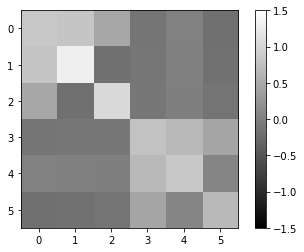

In [10]:
plt.imshow(cov_illustris['covariance'], vmin=-1.5, vmax=1.5, cmap='gray')
plt.colorbar()

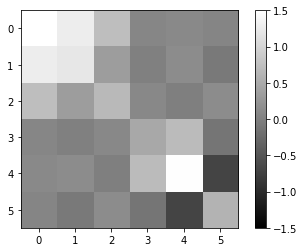

In [11]:
plt.imshow(cov_elvis['covariance'], vmin=-1.5, vmax=1.5, cmap='gray')
plt.colorbar()

In [12]:
def number_LG(data_mean, data_cov, n_sample=20):
    n_try = 10000
    n_out_list = np.ones(n_try)
    for i in range(n_try):
        data_random = np.random.multivariate_normal(data_mean, data_cov, size=n_sample)
        data_r_abs = np.abs(data_random)
        in_peak = (data_r_abs[:,0]< 2) & (data_r_abs[:,1]<2) & (data_r_abs[:,2]<2) &\
         (data_r_abs[:,3]< 2) & (data_r_abs[:,4]<2) & (data_r_abs[:,5]<2)
        out_peak = (data_r_abs[:,0]< 2) & (data_r_abs[:,1]<2) & (data_r_abs[:,2]<2) &\
         (data_random[:,3]< -2) & (data_random[:,4]<-2) & (data_r_abs[:,5]<2)
        n_in=np.count_nonzero(in_peak)
        n_out=np.count_nonzero(out_peak)
        n_out_list[i] = n_out
    return n_out_list

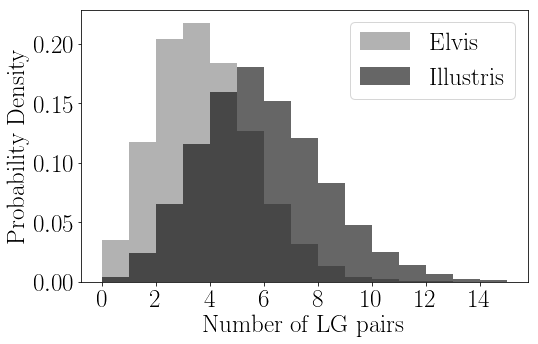

In [13]:
plt.figure(figsize=(8,5))
plt.rc('text', usetex=True,)
plt.rc('font', family='serif', size=25)

n_out_list = number_LG(cov_elvis['mean'], cov_elvis['covariance'], n_sample=500)
a = plt.hist(n_out_list, bins=np.linspace(0,15,16), 
             normed=True, label='Elvis', alpha=0.3, color='black')

n_out_list = number_LG(cov_illustris['mean'], cov_illustris['covariance'], n_sample=500)
a = plt.hist(n_out_list, bins=np.linspace(0,15,16), 
             normed=True, label='Illustris', alpha=0.6, color='black')

plt.legend()
plt.xlabel('Number of LG pairs')
plt.ylabel('Probability Density')
a = plt.xticks(np.linspace(0,14,8))
filename = "../paper/expected_numbers.pdf"
plt.savefig(filename, bbox_inches='tight')

In [14]:
data_random_elvis = np.random.multivariate_normal(cov_elvis['mean'], cov_elvis['covariance'], size=100000)
data_random_illustris = np.random.multivariate_normal(cov_illustris['mean'], cov_illustris['covariance'], size=100000)

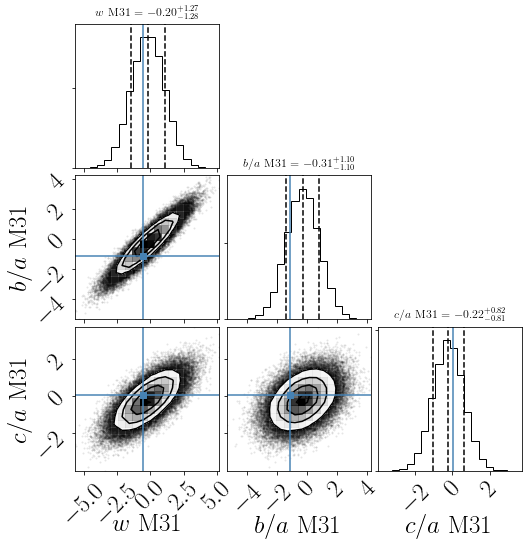

In [15]:
figure = corner.corner(data_random_elvis[:,0:3], 
                      quantiles=[0.16, 0.5, 0.84],
                      labels=[r"$w$ M31", r"$b/a$ M31", r"$c/a$ M31"],
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                      truths=cov_illustris['data_obs'][0:3])
filename = "../paper/gaussian_model_elvis_M31.pdf"
plt.savefig(filename, bbox_inches='tight')

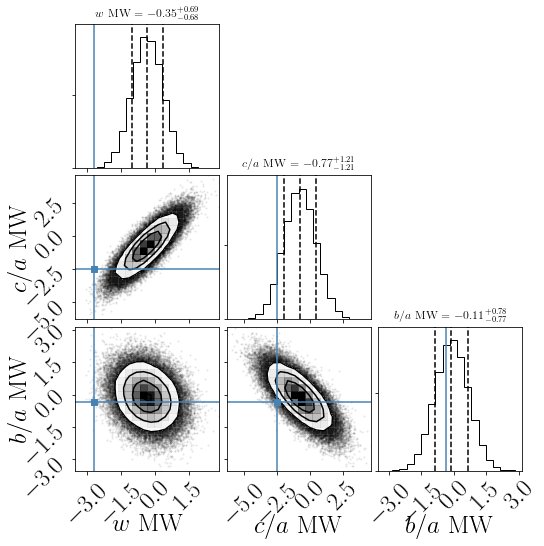

In [16]:
figure = corner.corner(data_random_elvis[:,3:6], 
                      quantiles=[0.16, 0.5, 0.84],
                      labels=[r"$w$ MW", r"$c/a$ MW", r"$b/a$ MW"],
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                      truths=cov_elvis['data_obs'][3:6])
filename = "../paper/gaussian_model_elvis_MW.pdf"
plt.savefig(filename, bbox_inches='tight')

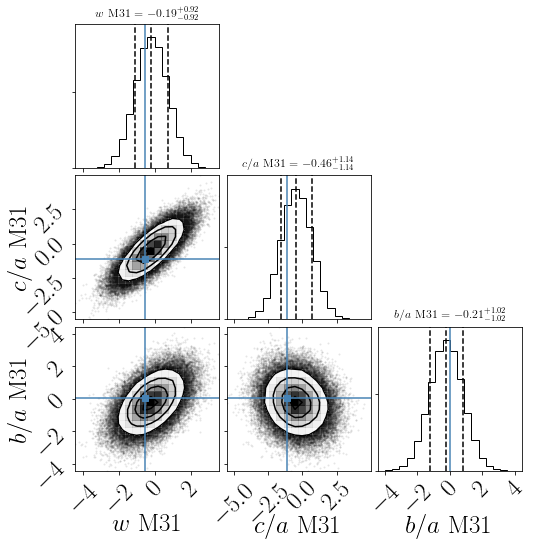

In [17]:
figure = corner.corner(data_random_illustris[:,0:3], 
                      quantiles=[0.16, 0.5, 0.84],
                      labels=[r"$w$ M31", r"$c/a$ M31", r"$b/a$ M31"],
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                      truths=cov_illustris['data_obs'][0:3])
filename = "../paper/gaussian_model_illustris_M31.pdf"
plt.savefig(filename, bbox_inches='tight')

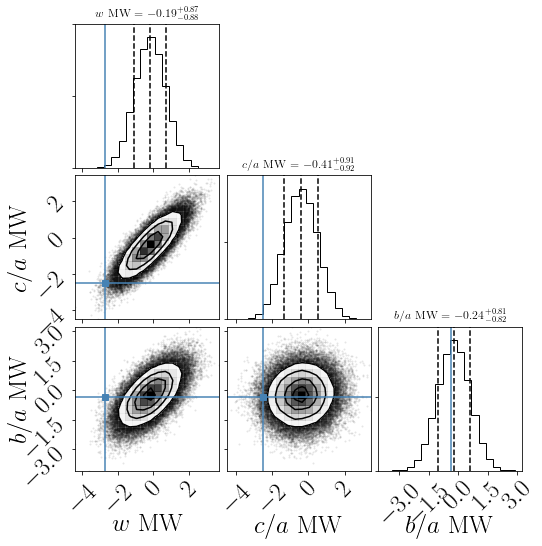

In [18]:
figure = corner.corner(data_random_illustris[:,3:6], 
                      quantiles=[0.16, 0.5, 0.84],
                      labels=[r"$w$ MW", r"$c/a$ MW", r"$b/a$ MW"],
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                      truths=cov_illustris['data_obs'][3:6])
filename = "../paper/gaussian_model_illustris_MW.pdf"
plt.savefig(filename, bbox_inches='tight')

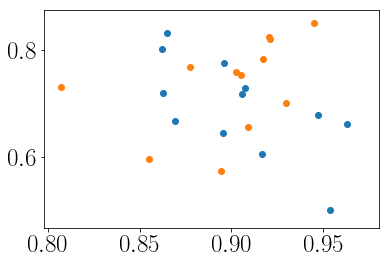

In [19]:
plt.scatter(MW_sim_vmax_sorted_elvis['ba_ratio'], MW_sim_vmax_sorted_elvis['ca_ratio'])
plt.scatter(M31_sim_vmax_sorted_elvis['ba_ratio'], M31_sim_vmax_sorted_elvis['ca_ratio'])
